## 5 encontro

- Plotar o grafico da melhor fitness (melhor e media) por geração -check

- Grafico de convergencia com os dados associados -check

- gerações = 100 , pop = 20, 90% crossover e 5% mutação -check

- Funcoes Objetivos: Rastrigin, optmization


- Implementar repopulação -check

- Nao apagar os clones 

- Apresentar a melhor solução no final - Valores das variaveis de decisão e valor da aptidão -check


- Armazenar varias execuções do algoritimo em sequencia e extrair media e desvio padrão da melhor solução e dos tempos de execução

- Elitisimo simples (melhor individuo da geração preservado) -check

- Funcao que faz RCE e chamar a cada 20% do numero de gerações total e registrar na toolbox -check


## Solid

In [1]:
import numpy as np
import math
from deap import base, creator, tools
import random
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
import json
import pandas as pd

In [2]:

class Setup:
    def __init__(self):
        self.CXPB, self.MUTPB, self.NGEN, self.POP_SIZE = 0.9, 0.05, 100, 100
        self.IND_SIZE = 10
        self.evaluations = 0

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)
        
        self.toolbox = base.Toolbox()
        self.toolbox.register("attribute", random.random)
        self.toolbox.register("individual", tools.initRepeat, creator.Individual, self.toolbox.attribute, n=self.IND_SIZE)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        
        self.toolbox.register("mate", tools.cxTwoPoint)
        self.toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
        self.toolbox.register("select", tools.selTournament, tournsize=3)
        self.toolbox.register("evaluate", self.evaluate)

    def evaluate(self, individual):
        self.evaluations += 1
        rastrigin = 10 * self.IND_SIZE
        for i in range(self.IND_SIZE):
            rastrigin += (individual[i]*individual[i] - 10 * (math.cos(2*np.pi*individual[i])))
        return rastrigin

    def rosenbrock(self,x):
        return np.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)


    def globalSolutions(self):
        # Definição das dimensões do espaço de busca
        n_dimensions = 2

        try:
            # Busca pelo ótimo global da função Rastrigin
            rastrigin_result = minimize(self.evaluate, x0=np.zeros(n_dimensions), method='BFGS')
            rastrigin_minimum = rastrigin_result.fun
            rastrigin_solution = rastrigin_result.x

            # Busca pelo ótimo global da função Rosenbrock
            rosenbrock_result = minimize(self.rosenbrock, x0=np.zeros(n_dimensions), method='BFGS')
            rosenbrock_minimum = rosenbrock_result.fun
            rosenbrock_solution = rosenbrock_result.x

        except Exception as e:
            print("Erro ao tentar encontrar o ótimo global das funções: ", e)
            

        # Impressão dos resultados
        print("\n\nÓtimo global da função Rastrigin: ", rastrigin_minimum)
        print("Solução: ", rastrigin_solution)
        print()
        print("Ótimo global da função Rosenbrock: ", rosenbrock_minimum)
        print("Solução: ", rosenbrock_solution)




In [3]:

class DataExploration:

    def __init__(self):
        self.fit_array = []

        # Função para calcular a média dos valores de fitness de cada geração
    def calculate_stats(self,logbook):

        fit_avg = logbook.select("avg")
        fit_std = logbook.select("std")
        fit_min = logbook.select("min")
        fit_max = logbook.select("max")
        self.fit_array.append(fit_min)
        self.fit_array.append(fit_avg)
        self.fit_array.append(fit_max)
        self.fit_array.append(fit_std)


        return {
            "min_fitness": fit_min,
            "max_fitness": fit_max,
            "avg_fitness":fit_avg,
            "std_fitness": fit_std
        }


    def visualize(self,logbook,pop):      
        generation = logbook.select("gen")
        statics = self.calculate_stats(logbook)
        best_solution_index = statics["min_fitness"].index(min( statics["min_fitness"]))
        best_solution_variables = pop[best_solution_index]
        best_solution_fitness =  statics["min_fitness"][best_solution_index]

        print("\nBest solution variables =\n", best_solution_variables)
        print("\nBest solution fitness = ", best_solution_fitness)

        self.grafico_convergencia(generation,statics)
        self.plot_diversity(generation,logbook)
        


    def grafico_convergencia(self,gen,lista):
        """ A convergência refere-se à tendência do algoritmo em direção a uma solução ótima. Pode ser avaliada visualmente observando o comportamento da média, mediana ou melhor fitness ao longo das gerações. Se esses valores estiverem estabilizando ou melhorando, indica que o algoritmo está convergindo."""
        fig, ax1 = plt.subplots()
        line1 = ax1.plot(gen, lista["min_fitness"], "*b-", label="Minimum Fitness")
        line2 = ax1.plot(gen, lista["avg_fitness"], "+r-", label="Average Fitness")
        line3 = ax1.plot(gen, lista["max_fitness"], "og-", label="Maximum Fitness")
        ax1.set_xlabel("Generation")
        ax1.set_ylabel("Fitness")
        lns = line1 + line2 + line3
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc="upper right")
        plt.show()

    def plot_population(self,population):
        # Extrair os valores das variáveis de decisão dos indivíduos
        x_values = [ind[0] for ind in population]
        y_values = [ind[1] for ind in population]

        # Plotar os valores das variáveis de decisão
        plt.scatter(x_values, y_values, c='b', label='Population')

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Population Behavior')
        plt.legend()
        plt.grid(True)
        plt.show()    

    


    def graficoBarrasFitnessGeneration(self,best_solutions_array, num_gen,fitness_mean):
        fig, ax = plt.subplots()
        generations = np.arange(2, num_gen + 1)
        print(len(generations))
        best_solutions = [best[0] for best in best_solutions_array if best]
        print(len(best_solutions))

    
        
        # Plotagem dos valores de melhor fitness por geração
        ax.bar(generations, best_solutions, color='b', label='Melhor Fitness')
        
        # Linha da média
        ax.axhline(y=fitness_mean, color='r', linestyle='--', label='Média Fitness')
        
        ax.set_xlabel('Geração')
        ax.set_ylabel('Fitness')
        ax.set_title('Melhor Fitness por Geração')
        ax.legend()
        plt.show()

    def plot_diversity(self,gen,logbook):
        diversity = logbook.select("diversity")
        print(f"Diversidade :  {diversity}")

        plt.plot(gen, diversity, "-b")
        plt.xlabel("Generation")
        plt.ylabel("Diversity")
        plt.title("Population Diversity")
        plt.show()



In [4]:


class AlgEvolution:
    def __init__(self, setup):
        self.setup = setup
        self.stats = tools.Statistics(key=lambda ind: ind.fitness.values)
        self.stats.register("avg", np.mean)
        self.stats.register("std", np.std)
        self.stats.register("min", np.min)
        self.stats.register("max", np.max)
        self.logbook = tools.Logbook()
        self.hof = tools.HallOfFame(1)
        self.pop = self.setup.toolbox.population(n=self.setup.POP_SIZE)
        self.hof.update(self.pop)

        self.best_solutions_array = []
        self.best_individual_array =[]
        self.data = {}
        self.repopulation_counter = 0


    def apply_elitism(self, population):
        # Sort the population based on fitness
        population.sort(key=lambda x: x.fitness.values)

        # Replace the worst individuals with the best individuals from the Hall of Fame
        for i in range(len(self.hof)):
            population[-(i+1)] = self.setup.toolbox.clone(self.hof[i])
            
    def calculaTempo(self,x1,x2):
        return x1 - x2

    def repopulate(self):
        # Selecionar os melhores indivíduos da Hall of Fame
        best_individuals = self.hof[:self.setup.POP_SIZE]

        # Clonar os melhores indivíduos para criar uma nova população
        new_population = [self.setup.toolbox.clone(ind) for ind in best_individuals]

        # Substituir a população atual pela nova população
        self.pop[:] = new_population

    def repopulate_best_individuals(self):
        if self.repopulation_counter == 25:
            # Repopulação apenas dos melhores indivíduos
            best_individuals = self.hof[:self.setup.POP_SIZE]
            self.pop = best_individuals
            self.repopulation_counter = 0

    def run(self):
        
        #! Evaluate the entire population
        fitnesses = map(self.setup.toolbox.evaluate, self.pop)
        for ind, fit in zip(self.pop, fitnesses):
            ind.fitness.values = [fit]



        for g in range(self.setup.NGEN):

            # Aplicar repopulação a cada 25 gerações
            if (g + 1) % 25 == 0:
                print("\nRCE sendo aplicado!")
                #self.repopulate()

            # Select the next generation individuals
            offspring = self.setup.toolbox.select(self.pop, k=len(self.pop))

            # Clone the selected individuals
            offspring = [self.setup.toolbox.clone(ind) for ind in offspring]

            #! Apply crossover and mutation on the offspring
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < self.setup.CXPB:
                    self.setup.toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values

            for mutant in offspring:
                if random.random() < self.setup.MUTPB:
                    self.setup.toolbox.mutate(mutant)
                    del mutant.fitness.values

            # Evaluate the individuals with an invalid fitness
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(self.setup.toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = [fit]

            # The population is entirely replaced by the offspring
            self.pop[:] = offspring

            #! Repopular os melhores indivíduos a cada 25 gerações
            #self.repopulate_best_individuals()



            #! Dados da geração
            #print(f"Geração {g+1} - Melhor individuo = {self.hof[0]} - Fit = {self.hof[0].fitness}",)
            print(f"Geração {g+1} - Melhor individuo = {round(self.hof[0][0],2)} - Fit = {self.hof[0].fitness}",)
            self.best_solutions_array.append(self.hof[0].fitness.values)
            print(f"Evaluations = {self.setup.evaluations}\n")
            self.data["Generations"] = g+1
            self.data["Best Solution"] = round(self.hof[0][0],2)
            self.data["Evaluations"] = self.setup.evaluations
            #data["Media da Geração"]= self.stats["avg"]
            self.best_individual_array.append(self.data)

            #! Elitism            
            # Update best with new pop
            self.hof.update(self.pop) 

            # Update pop with best
            self.pop[0] = self.setup.toolbox.clone(self.hof[0])

            # Apply elitism
            self.apply_elitism(self.pop)



            #! Save each generation record in the logbook
            record = self.stats.compile(self.pop)
            self.logbook.record(gen=g, **record)
            # Incrementar o contador de gerações para a repopulação
            self.repopulation_counter += 1

        print(self.best_individual_array)
        best_df = pd.read_json(json.dumps(self.best_individual_array),orient='records')
        display(best_df)

        return self.pop, self.logbook, self.hof[0]


Geração 1 - Melhor individuo = 0.1 - Fit = ()
Evaluations = 188

Geração 2 - Melhor individuo = 0.0 - Fit = (36.83492231962185,)
Evaluations = 278

Geração 3 - Melhor individuo = 0.0 - Fit = (26.271708626631643,)
Evaluations = 369

Geração 4 - Melhor individuo = 0.0 - Fit = (22.934626928783437,)
Evaluations = 465

Geração 5 - Melhor individuo = 0.0 - Fit = (18.867563170225047,)
Evaluations = 556

Geração 6 - Melhor individuo = 0.0 - Fit = (14.793051072760496,)
Evaluations = 645

Geração 7 - Melhor individuo = 0.0 - Fit = (8.53285238704658,)
Evaluations = 737

Geração 8 - Melhor individuo = 0.0 - Fit = (6.785792681269291,)
Evaluations = 829

Geração 9 - Melhor individuo = 0.0 - Fit = (6.229937471608377,)
Evaluations = 917

Geração 10 - Melhor individuo = 0.0 - Fit = (5.613179525706425,)
Evaluations = 1004

Geração 11 - Melhor individuo = 0.0 - Fit = (4.593800649748918,)
Evaluations = 1100

Geração 12 - Melhor individuo = 0.0 - Fit = (4.593800649748918,)
Evaluations = 1186

Geração 13 - 

/tmp/ipykernel_388043/2207987127.py:126: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  best_df = pd.read_json(json.dumps(self.best_individual_array),orient='records')


,Generations,Best Solution,Evaluations
0,100,0,9100
1,100,0,9100
2,100,0,9100
3,100,0,9100
4,100,0,9100
...,...,...,...
95,100,0,9100
96,100,0,9100
97,100,0,9100
98,100,0,9100



Best solution variables =
 [0.002351766408469458, 0.9834457368130209, -0.9871185745660753, 0.027499043430944337, 0.03373772261981256, 0.014165784688255557, 0.013852755675209383, 0.009002246610448461, -0.004598078915388125, -0.012222711885787486]

Best solution fitness =  2.531800205157074


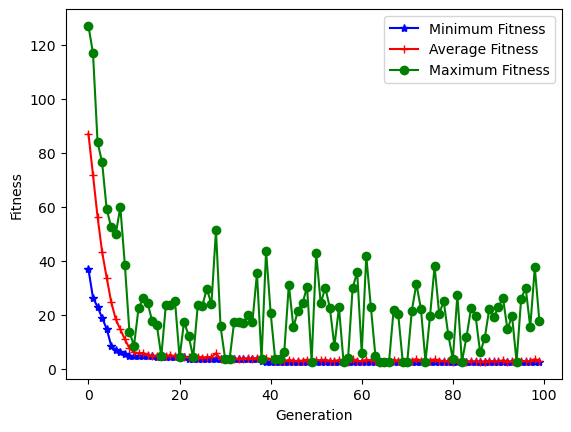

Diversidade :  [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


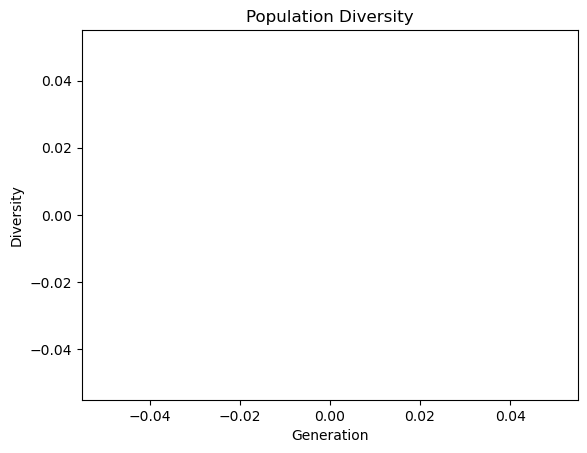

99
99


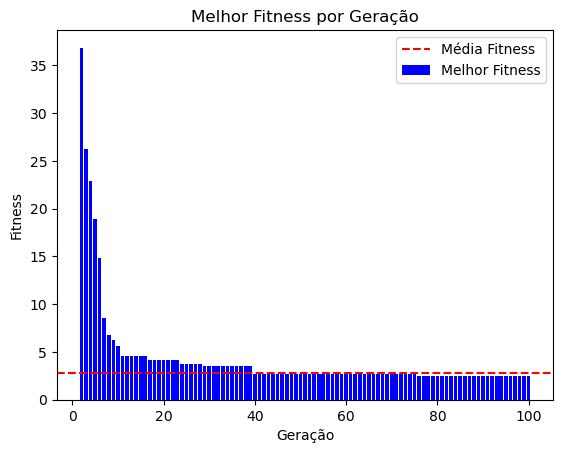

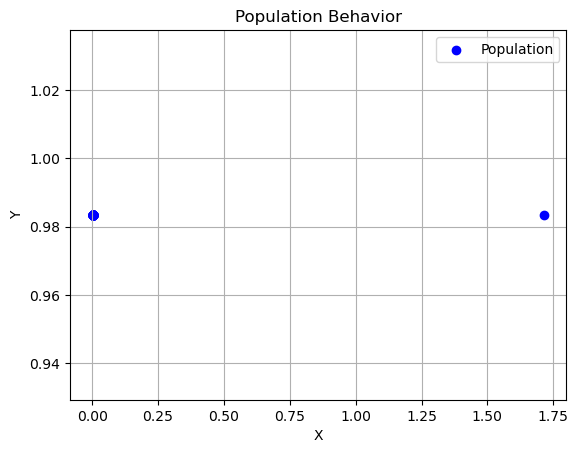

Tempo total de execução: 1.31 segundos


In [5]:


def main():     
    tempo1 = time.time()


    #!setup
    data_visual = DataExploration()
    setup = Setup()
    alg = AlgEvolution(setup)

    #!loop
    #setup.globalSolutions()
    pop, logbook, best = alg.run()
    stats_data = data_visual.calculate_stats(logbook)
    media = stats_data["avg_fitness"]

    #!Results           
    #print("Best solution variables \n", best)
    #print("Best solution fitness \n", best.fitness)
    data_visual.visualize(logbook,pop)
    data_visual.graficoBarrasFitnessGeneration(alg.best_solutions_array,setup.NGEN,media.pop())
    
    # Plotar o comportamento da população usando repopulação dos melhores indivíduos
    data_visual.plot_population(pop)



    tempo2 = time.time()    
    print(f"Tempo total de execução: {round(tempo2-tempo1,2)} segundos",)    


if __name__ == "__main__":
    main()